In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from statistics import mode
import re
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('h1b_kaggle.csv')

In [3]:
df.info()
df.head()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
CASE_ID               1048575 non-null int64
CASE_STATUS           1048575 non-null object
EMPLOYER_NAME         1048556 non-null object
SOC_NAME              1048564 non-null object
JOB_TITLE             1048567 non-null object
FULL_TIME_POSITION    1048574 non-null object
PREVAILING_WAGE       1048571 non-null float64
YEAR                  1048575 non-null int64
WORKSITE              1048575 non-null object
lon                   1019007 non-null float64
lat                   1019007 non-null float64
dtypes: float64(3), int64(2), object(6)
memory usage: 88.0+ MB


,CASE_ID,PREVAILING_WAGE,YEAR,lon,lat
count,1.048575e+06,1.048571e+06,1.048575e+06,1.019007e+06,1.019007e+06
mean,5.242880e+05,8.942724e+04,2.015618e+03,-9.224186e+01,3.816965e+01
std,3.026977e+05,1.643214e+06,4.859268e-01,1.936639e+01,4.606127e+00
min,1.000000e+00,0.000000e+00,2.015000e+03,-1.578583e+02,1.343719e+01
25%,2.621445e+05,5.636800e+04,2.015000e+03,-1.118910e+02,3.415175e+01
50%,5.242880e+05,6.651800e+04,2.016000e+03,-8.648955e+01,3.908400e+01
75%,7.864315e+05,8.247200e+04,2.016000e+03,-7.559826e+01,4.088374e+01
max,1.048575e+06,3.291392e+08,2.016000e+03,1.457298e+02,6.483778e+01


In [4]:
df['CASE_STATUS'].unique()
df.head(10)

,CASE_ID,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,1,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016,"ANN ARBOR, MICHIGAN",-83.743038,42.280826
1,2,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016,"PLANO, TEXAS",-96.698886,33.019843
2,3,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016,"JERSEY CITY, NEW JERSEY",-74.077642,40.728158
3,4,CERTIFIED-WITHDRAWN,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",Y,220314.0,2016,"DENVER, COLORADO",-104.990251,39.739236
4,5,WITHDRAWN,PEABODY INVESTMENTS CORP.,CHIEF EXECUTIVES,PRESIDENT MONGOLIA AND INDIA,Y,157518.4,2016,"ST. LOUIS, MISSOURI",-90.199404,38.627003
5,6,CERTIFIED-WITHDRAWN,BURGER KING CORPORATION,CHIEF EXECUTIVES,"EXECUTIVE V P, GLOBAL DEVELOPMENT AND PRESIDEN...",Y,225000.0,2016,"MIAMI, FLORIDA",-80.191790,25.761680
6,7,CERTIFIED-WITHDRAWN,BT AND MK ENERGY AND COMMODITIES,CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,91021.0,2016,"HOUSTON, TEXAS",-95.369803,29.760427
7,8,CERTIFIED-WITHDRAWN,"GLOBO MOBILE TECHNOLOGIES, INC.",CHIEF EXECUTIVES,CHIEF OPERATIONS OFFICER,Y,150000.0,2016,"SAN JOSE, CALIFORNIA",-121.886329,37.338208
8,9,CERTIFIED-WITHDRAWN,ESI COMPANIES INC.,CHIEF EXECUTIVES,PRESIDENT,Y,127546.0,2016,"MEMPHIS, TEXAS",NaN,NaN
9,10,WITHDRAWN,LESSARD INTERNATIONAL LLC,CHIEF EXECUTIVES,PRESIDENT,Y,154648.0,2016,"VIENNA, VIRGINIA",-77.265260,38.901222


In [5]:
import warnings
warnings.filterwarnings("ignore")
df.CASE_STATUS[df['CASE_STATUS']=='REJECTED'] = 'DENIED'
df.CASE_STATUS[df['CASE_STATUS']=='INVALIDATED'] = 'DENIED'
df.CASE_STATUS[df['CASE_STATUS']=='PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED'] = 'DENIED'
df.CASE_STATUS[df['CASE_STATUS']=='CERTIFIED-WITHDRAWN'] = 'CERTIFIED'

In [6]:
##Drop rows with withdrawn
df.EMPLOYER_NAME.describe()
df = df.drop(df[df.CASE_STATUS == 'WITHDRAWN'].index)

## Storing non null in df w.r.t. case status
df = df[df['CASE_STATUS'].notnull()]
print(df['CASE_STATUS'].value_counts())

CERTIFIED    997411
DENIED        15670
Name: CASE_STATUS, dtype: int64


In [7]:
print(70606/(70606+2114025))

0.03231941687177377


In [8]:
##check count of NAN
count_nan = len(df) - df.count()
print(count_nan)

CASE_ID                   0
CASE_STATUS               0
EMPLOYER_NAME            12
SOC_NAME                  6
JOB_TITLE                 3
FULL_TIME_POSITION        1
PREVAILING_WAGE           3
YEAR                      0
WORKSITE                  0
lon                   28104
lat                   28104
dtype: int64


In [9]:
## Filling na in employer name with mode
df['EMPLOYER_NAME'] = df['EMPLOYER_NAME'].fillna(df['EMPLOYER_NAME'].mode()[0])

In [10]:
assert pd.notnull(df['EMPLOYER_NAME']).all().all()

In [11]:
##to check the percentile in wages
print(np.nanpercentile(df.PREVAILING_WAGE,98))
df.PREVAILING_WAGE.median()

138757.0


66518.0

In [12]:
## replacing min and max with 2 and 98 percentile
df.loc[df.PREVAILING_WAGE < 34029, 'PREVAILING_WAGE'] = 34029
df.loc[df['PREVAILING_WAGE'] > 138703, 'PREVAILING_WAGE'] = 138703
df.PREVAILING_WAGE.fillna(df.PREVAILING_WAGE.mean(), inplace = True)

In [13]:
## Filling na in JOB_TITLE and FULL_TIME_POSITION with mode
df['JOB_TITLE'] = df['JOB_TITLE'].fillna(df['JOB_TITLE'].mode()[0])
df['FULL_TIME_POSITION'] = df['FULL_TIME_POSITION'].fillna(df['FULL_TIME_POSITION'].mode()[0])
df['SOC_NAME'] = df['SOC_NAME'].fillna(df['SOC_NAME'].mode()[0])

In [14]:
foo1 = df['FULL_TIME_POSITION']=='Y'
foo2 = df['CASE_STATUS']=='CERIFIED'
print(len(df[foo1])/len(df))

fooy = df.FULL_TIME_POSITION[df['FULL_TIME_POSITION']=='Y'].count()
foox = df.CASE_STATUS[df['CASE_STATUS']=='CERTIFIED'].count()
print(fooy/df.FULL_TIME_POSITION.count())

0.655259549828691
0.655259549828691


In [15]:
# Dropping lat and lon columns
df = df.drop('lat', axis = 1)
df = df.drop('lon', axis = 1)


In [16]:
df['NEW_EMPLOYER'] = np.nan
df.shape

(1013081, 10)

In [17]:
warnings.filterwarnings("ignore")

df['EMPLOYER_NAME'] = df['EMPLOYER_NAME'].str.lower()
df.NEW_EMPLOYER[df['EMPLOYER_NAME'].str.contains('university')] = 'university'
df['NEW_EMPLOYER'] = df.NEW_EMPLOYER.replace(np.nan, 'non university', regex=True)

In [18]:
# Creating occupation and mapping the values
warnings.filterwarnings("ignore")

df['OCCUPATION'] = np.nan
df['SOC_NAME'] = df['SOC_NAME'].str.lower()
df.OCCUPATION[df['SOC_NAME'].str.contains('computer','programmer')] = 'computer occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('software','web developer')] = 'computer occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('database')] = 'computer occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('math','statistic')] = 'Mathematical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('predictive model','stats')] = 'Mathematical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('teacher','linguist')] = 'Education Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('professor','Teach')] = 'Education Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('school principal')] = 'Education Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('medical','doctor')] = 'Medical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('physician','dentist')] = 'Medical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('Health','Physical Therapists')] = 'Medical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('surgeon','nurse')] = 'Medical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('psychiatr')] = 'Medical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('chemist','physicist')] = 'Advance Sciences'
df.OCCUPATION[df['SOC_NAME'].str.contains('biology','scientist')] = 'Advance Sciences'
df.OCCUPATION[df['SOC_NAME'].str.contains('biologi','clinical research')] = 'Advance Sciences'
df.OCCUPATION[df['SOC_NAME'].str.contains('public relation','manage')] = 'Management Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('management','operation')] = 'Management Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('chief','plan')] = 'Management Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('executive')] = 'Management Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('advertis','marketing')] = 'Marketing Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('promotion','market research')] = 'Marketing Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('business','business analyst')] = 'Business Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('business systems analyst')] = 'Business Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('accountant','finance')] = 'Financial Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('financial')] = 'Financial Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('engineer','architect')] = 'Architecture & Engineering'
df.OCCUPATION[df['SOC_NAME'].str.contains('surveyor','carto')] = 'Architecture & Engineering'
df.OCCUPATION[df['SOC_NAME'].str.contains('technician','drafter')] = 'Architecture & Engineering'
df.OCCUPATION[df['SOC_NAME'].str.contains('information security','information tech')] = 'Architecture & Engineering'
df['OCCUPATION']= df.OCCUPATION.replace(np.nan, 'Others', regex=True)

In [19]:
## Splitting city and state and capturing state in another variable
df['state'] = df.WORKSITE.str.split('\s+').str[-1]

In [20]:
print(df.head())

   CASE_ID CASE_STATUS                                      EMPLOYER_NAME  \
0        1   CERTIFIED                             university of michigan   
1        2   CERTIFIED                             goodman networks, inc.   
2        3   CERTIFIED                          ports america group, inc.   
3        4   CERTIFIED  gates corporation, a wholly-owned subsidiary o...   
5        6   CERTIFIED                            burger king corporation   

                        SOC_NAME  \
0  biochemists and biophysicists   
1               chief executives   
2               chief executives   
3               chief executives   
5               chief executives   

                                           JOB_TITLE FULL_TIME_POSITION  \
0                       POSTDOCTORAL RESEARCH FELLOW                  N   
1                            CHIEF OPERATING OFFICER                  Y   
2                              CHIEF PROCESS OFFICER                  Y   
3                   

In [21]:
from sklearn import preprocessing
class_mapping = {'CERTIFIED':0, 'DENIED':1}
df["CASE_STATUS"] = df["CASE_STATUS"].map(class_mapping)

In [22]:
print(df.head())

   CASE_ID  CASE_STATUS                                      EMPLOYER_NAME  \
0        1            0                             university of michigan   
1        2            0                             goodman networks, inc.   
2        3            0                          ports america group, inc.   
3        4            0  gates corporation, a wholly-owned subsidiary o...   
5        6            0                            burger king corporation   

                        SOC_NAME  \
0  biochemists and biophysicists   
1               chief executives   
2               chief executives   
3               chief executives   
5               chief executives   

                                           JOB_TITLE FULL_TIME_POSITION  \
0                       POSTDOCTORAL RESEARCH FELLOW                  N   
1                            CHIEF OPERATING OFFICER                  Y   
2                              CHIEF PROCESS OFFICER                  Y   
3             

In [23]:
test1 = pd.Series(df['JOB_TITLE'].ravel()).unique()
print(pd.DataFrame(test1))

                                                        0
0                            POSTDOCTORAL RESEARCH FELLOW
1                                 CHIEF OPERATING OFFICER
2                                   CHIEF PROCESS OFFICER
3                             REGIONAL PRESIDEN, AMERICAS
4       EXECUTIVE V P, GLOBAL DEVELOPMENT AND PRESIDEN...
5                                CHIEF OPERATIONS OFFICER
6                                               PRESIDENT
7          CHIEF INFORMATION OFFICER, HEINZ NORTH AMERICA
8        VICE PRESIDENT AND CHIEF HUMAN RESOURCES OFFICER
9                                       TREASURER AND COO
10                               CHIEF COMMERCIAL OFFICER
11                                           BOARD MEMBER
12                                CHIEF FINANCIAL OFFICER
13                              VICE PRESIDENT OF FINANCE
14                            GENERAL MANAGER, OPERATIONS
15                                                    CEO
16            

In [25]:
# dropping these columns
df = df.drop('EMPLOYER_NAME', axis = 1)
df = df.drop('SOC_NAME', axis = 1)
df = df.drop('JOB_TITLE', axis = 1)
df = df.drop('WORKSITE', axis = 1)
df = df.drop('CASE_ID', axis = 1)

In [26]:
df1 = df.copy()

In [27]:
df1[['CASE_STATUS', 'FULL_TIME_POSITION', 'YEAR','NEW_EMPLOYER','OCCUPATION','state']] = df1[['CASE_STATUS', 'FULL_TIME_POSITION', 'YEAR','NEW_EMPLOYER','OCCUPATION','state']].apply(lambda x: x.astype('category'))

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1013081 entries, 0 to 1048574
Data columns (total 7 columns):
CASE_STATUS           1013081 non-null category
FULL_TIME_POSITION    1013081 non-null category
PREVAILING_WAGE       1013081 non-null float64
YEAR                  1013081 non-null category
NEW_EMPLOYER          1013081 non-null category
OCCUPATION            1013081 non-null category
state                 1013081 non-null category
dtypes: category(6), float64(1)
memory usage: 21.3 MB


In [28]:
X = df.drop('CASE_STATUS', axis=1)
y = df.CASE_STATUS

seed = 7
test_size = 0.40

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
X_train.columns

Index(['FULL_TIME_POSITION', 'PREVAILING_WAGE', 'YEAR', 'NEW_EMPLOYER',
       'OCCUPATION', 'state'],
      dtype='object')

In [29]:
print(X_train.isnull().sum())

FULL_TIME_POSITION    0
PREVAILING_WAGE       0
YEAR                  0
NEW_EMPLOYER          0
OCCUPATION            0
state                 0
dtype: int64


In [30]:
X_train_encode = pd.get_dummies(X_train)
X_test_encode = pd.get_dummies(X_test)

In [31]:
y_train.head()

744908    0
188172    0
230893    0
287459    0
66909     0
Name: CASE_STATUS, dtype: int64

In [32]:
train_X = X_train_encode.as_matrix()
train_y = y_train.as_matrix()

In [33]:
import xgboost
gbm = xgboost.XGBClassifier(max_features='sqrt', subsample=0.8, random_state=10)

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
parameters = [{'n_estimators': [10,100]},
              {'learning_rate': [0.1, 0.01, 0.5]}]

In [36]:
grid_search = GridSearchCV(estimator = gbm, param_grid = parameters, scoring='accuracy', cv = 3, n_jobs=-1)

In [37]:
grid_search = grid_search.fit(train_X, train_y)

In [46]:
warnings.filterwarnings("ignore")

#grid_search.grid_scores_, 
grid_search.best_params_, grid_search.best_score_

({'n_estimators': 10}, 0.98460634895566)

In [47]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, max_features='sqrt', min_child_weight=1, missing=None,
       n_estimators=10, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=10, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

In [48]:
gbm=xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=3, max_features='sqrt', min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=10, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8).fit(train_X, train_y)

In [49]:
y_pred = gbm.predict(X_test_encode.as_matrix())

In [50]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[398920      0]
 [  6313      0]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    398920
           1       0.00      0.00      0.00      6313

   micro avg       0.98      0.98      0.98    405233
   macro avg       0.49      0.50      0.50    405233
weighted avg       0.97      0.98      0.98    405233



In [51]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.5

0.5


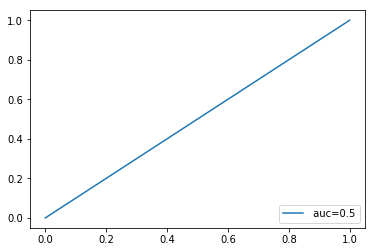

In [52]:
from sklearn import metrics
import matplotlib.pyplot as plt

fpr_xg, tpr_xg, thresholds = metrics.roc_curve(y_test, y_pred)
print(metrics.auc(fpr_xg, tpr_xg))
auc_xgb = np.trapz(tpr_xg,fpr_xg)
plt.plot(fpr_xg,tpr_xg,label=" auc="+str(auc_xgb))
plt.legend(loc=4)
plt.show()

In [53]:
import pickle
"""Saving the Model"""
XGB_Model_h1b = 'XGB_Model_h1b.sav'
pickle.dump(gbm, open(XGB_Model_h1b, 'wb'))